# Loans Prediction Models

## Project Dependencies

In [1]:
import pickle
from pathlib import Path

import m2cgen

import numpy as np

import pandas as pd

from sklearn import svm, tree
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

from imblearn.over_sampling import SMOTE

import seaborn as sns

from matplotlib import pyplot as plt 

## Data Inspection

In [2]:
df = pd.read_csv('./loan_data_set.csv')
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Y


### How many unique values per column (show at most 5 ones) ?

In [3]:
print('unique values in each column(at most show 5 values):\n')
for column in df.columns:
    unique_values = df[column].unique()  
    print(f"{column}: ({unique_values.shape[0]} values) \t => \t {unique_values[:5]}")

unique values in each column(at most show 5 values):

Loan_ID: (614 values) 	 => 	 ['LP001002' 'LP001003' 'LP001005' 'LP001006' 'LP001008']
Gender: (3 values) 	 => 	 ['Male' 'Female' nan]
Married: (3 values) 	 => 	 ['No' 'Yes' nan]
Dependents: (5 values) 	 => 	 ['0' '1' '2' '3+' nan]
Education: (2 values) 	 => 	 ['Graduate' 'Not Graduate']
Self_Employed: (3 values) 	 => 	 ['No' 'Yes' nan]
ApplicantIncome: (505 values) 	 => 	 [5849 4583 3000 2583 6000]
CoapplicantIncome: (287 values) 	 => 	 [   0. 1508. 2358. 4196. 1516.]
LoanAmount: (204 values) 	 => 	 [ nan 128.  66. 120. 141.]
Loan_Amount_Term: (11 values) 	 => 	 [360. 120. 240.  nan 180.]
Credit_History: (3 values) 	 => 	 [ 1.  0. nan]
Loan_Status: (2 values) 	 => 	 ['Y' 'N']


In [4]:
# Credit_History is either 0 or 1 or missing, we can use it as string if defined
df['Credit_History'] = df['Credit_History'].transform(lambda v: str(int(v)) if v == 0 or v == 1 else v)
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1,Y


### How many missing values per column ?

Missing values count:

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Loan_Status           0
dtype: int64


<AxesSubplot: xlabel='index'>

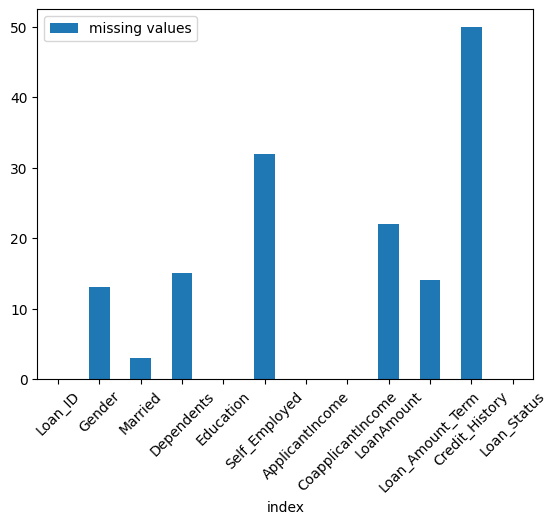

In [5]:
print('Missing values count:\n')
print(df.isna().sum())
df.isna().sum().reset_index(name='missing values').plot.bar(x='index', y='missing values', rot=45)

## Data Preprocessing

In [6]:
# drop the Loan_ID column since it is irrelevant to prediction, *inplace*
df.drop(columns=['Loan_ID'], inplace=True)


# fill the missing values in 'LoanAmount' column with the mean in this column, *inplace*
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)


# replace the missing values in all columns except the 'LoadAmount'
# with the mode in each column respectively, *inplace*
columns_to_replace_with_mode = [column for column in df.columns[:-1] if column != 'LoanAmount']

for column in columns_to_replace_with_mode:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [7]:
# now there shouldn't be any missing values
print('now number of missing values becomes equal to:', df.isna().sum().sum())

now number of missing values becomes equal to: 0


### now what are the unique values in each column (show at most 5)

In [8]:
for column in df.columns:
    unique_values = df[column].unique()  
    print(f"{column}:({unique_values.shape[0]} values) => {unique_values[:5]}")

Gender:(2 values) => ['Male' 'Female']
Married:(2 values) => ['No' 'Yes']
Dependents:(4 values) => ['0' '1' '2' '3+']
Education:(2 values) => ['Graduate' 'Not Graduate']
Self_Employed:(2 values) => ['No' 'Yes']
ApplicantIncome:(505 values) => [5849 4583 3000 2583 6000]
CoapplicantIncome:(287 values) => [   0. 1508. 2358. 4196. 1516.]
LoanAmount:(204 values) => [146.41216216 128.          66.         120.         141.        ]
Loan_Amount_Term:(10 values) => [360. 120. 240. 180.  60.]
Credit_History:(2 values) => ['1' '0']
Loan_Status:(2 values) => ['Y' 'N']


In [9]:
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1,Y
...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1,Y


In [10]:
ordered_columns = [
    "Gender",
    "Married",
    "Dependents",
    "Education",
    "Self_Employed",
    "ApplicantIncome",
    "CoapplicantIncome",
    "LoanAmount",
    "Loan_Amount_Term",
    "Credit_History",
]
discrete_column_names = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History']
continuous_column_names = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
prediction_column_name = 'Loan_Status'

### define **encoder** and **decoder**
- encoder: dict to convert text values into **discrete numeric** values
- decoder: dict to convert discrete numeric values into text values

In [11]:
discrete_column_encoder_dict = {
    "Gender": {"Female": 0, "Male": 1},
    "Married": {"No": 0, "Yes": 1},
    "Dependents": {"0": 0, "1": 1, "2": 2, "3+": 3},
    "Education": {"Not Graduate": 0, "Graduate": 1},
    "Self_Employed": {"No": 0, "Yes": 1},
    "Credit_History": {"0": 0, "1": 1},
    "Loan_Status": {"N": 0, "Y": 1},
}

discrete_column_decoder_dict = {
    "Gender": {0: "Female", 1: "Male"},
    "Married": {0: "No", 1: "Yes"},
    "Dependents": {0: "0", 1: "1", 2: "2", 3: "3+"},
    "Education": {0: "Not Graduate", 1: "Graduate"},
    "Self_Employed": {0: "No", 1: "Yes"},
    "Credit_History": {0: "0", 1: "1"},
    "Loan_Status": {0: "N", 1: "Y"},
}

In [12]:
# convert using the encoder dict
df.replace(discrete_column_encoder_dict, inplace=True)
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,1,0,0,1,0,5849,0.0,146.412162,360.0,1,1
1,1,1,1,1,0,4583,1508.0,128.000000,360.0,1,0
2,1,1,0,1,1,3000,0.0,66.000000,360.0,1,1
3,1,1,0,0,0,2583,2358.0,120.000000,360.0,1,1
4,1,0,0,1,0,6000,0.0,141.000000,360.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,1,0,2900,0.0,71.000000,360.0,1,1
610,1,1,3,1,0,4106,0.0,40.000000,180.0,1,1
611,1,1,1,1,0,8072,240.0,253.000000,360.0,1,1
612,1,1,2,1,0,7583,0.0,187.000000,360.0,1,1


In [13]:
def pie_plot(y, title='values ratio'):
    """utility function to plot pie representing percentages of each decisions in y"""

    fig, axes = plt.subplots(figsize=[6, 6])
    y_values_cnt = y.value_counts()
    axes.pie(x=y_values_cnt, labels=y_values_cnt.index.to_list(), autopct='%1.1f%%')
    axes.set_title(title)
    return plt

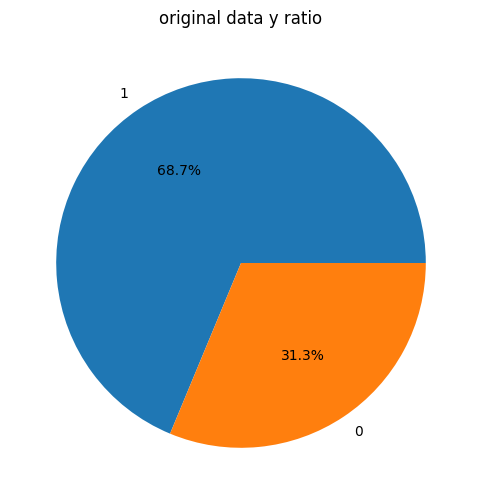

In [14]:
# ratio of yes/no in the original data
pie_plot(df['Loan_Status'], title='original data y ratio').show()

add examples to the original data so that yes/no decision are equal

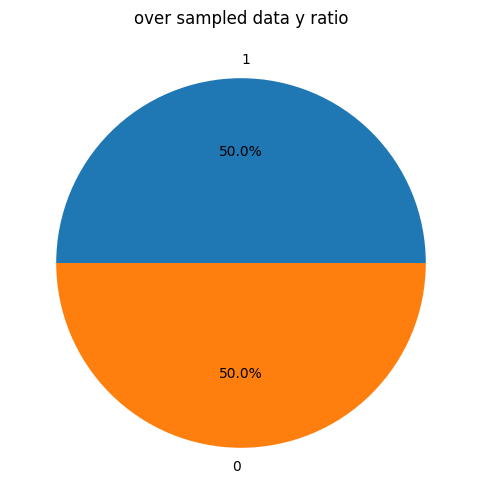

In [15]:
over_sample = SMOTE()

X_over_sampled, y_over_sampled = over_sample.fit_resample(df.drop('Loan_Status', axis=1), df['Loan_Status'])

pie_plot(y_over_sampled, title='over sampled data y ratio').show()

### Train/Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_over_sampled,
    y_over_sampled, 
    test_size=0.20, 
    random_state=1,
)

print('# training data', len(X_train))
print('# testing data', len(X_test))

# training data 675
# testing data 169


## .... Training The Models ....

`log_metrics` is utility function to print each metric result for a given (actual_y, predicted_y)
so that we can call it for each model 

metrics are:
- accuracy
- precision
- recall
- f1
- roc_auc

it prints also confusion_matrix

In [17]:
def log_metrics(actual_y, predicted_y, legend):
    metrics = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1': f1_score,
        'roc_auc': roc_auc_score,
    }
    
    print('*' * 20, legend, '*' * 20, end='\n\n')

    # accuracy  precision  recall  f1  roc_auc

    for metric_name, metric_fn in metrics.items():
        metric_res = metric_fn(actual_y, predicted_y)
        print(f'{metric_name}: {metric_res: .2f}')

    # confusion matrix
    
    conf_mat = confusion_matrix(actual_y, predicted_y)
    
    print('confusion matrix:')
    print(conf_mat)
    
    sns.heatmap(conf_mat, annot=True)
    
    print()
    
    # roc_auc
    false_positive, true_positive, _ = roc_curve(actual_y, predicted_y)

    auc = metrics['roc_auc'](actual_y, predicted_y)
    
    fig = plt.figure()
    plt.plot(false_positive, true_positive, label=f'auc = {auc: .2f}')
    plt.xlabel('true positive rate')
    plt.ylabel('false positive rate')
    plt.legend(loc=4)
    plt.show()
    
    print('-' * 100, end='\n\n\n\n')
    

### Naive Bayes Model

In [18]:
# utility function to predict bayes result using two models: discrete and continuous
# since discrete attributes trained in discrete model
#  and continuous attributes trained in continuous model
def bayes_predict(
    X,
    discrete_column_names,
    continuous_column_names,
    bayes_model_discrete,
    bayes_model_continuous, 
    *, 
    proba=False
):
    discrete_proba = bayes_model_discrete.predict_proba(X[discrete_column_names])
    continuous_proba = bayes_model_continuous.predict_proba(X[continuous_column_names])

    p0_discr = discrete_proba[:, 0]
    p1_discr = discrete_proba[:, 1]
    
    p0_cont = continuous_proba[:, 0]
    p1_cont = continuous_proba[:, 1]
    
    
    p0 = p0_discr * p0_cont 
    p1 = p1_discr * p1_cont
    
    
    p_sum = p0 + p1
    
    p0 /= p_sum
    p1 /= p_sum
    
    if proba:
        return np.array([p0, p1]).T

    p = (p1 >= p0) + 0
    
    return p
    

train two models:
  1. discrete: using `CategoricalNB`, trained only on the discrete attributes
  2. continuous: using `GaussianNB`, trained only on the continuous attributes

then use the function defined above `bayes_predict` to get the final prediction (or proba) 

In [19]:
bayes_model_discrete = CategoricalNB()
bayes_model_continuous = GaussianNB()

# training
bayes_model_discrete.fit(X_train[discrete_column_names] , y_train)
bayes_model_continuous.fit(X_train[continuous_column_names] , y_train)
      

# what are the predictions on y_train ?
y_train_bayes = bayes_predict(
    X=X_train, 
    discrete_column_names=discrete_column_names,
    continuous_column_names=continuous_column_names,
    bayes_model_discrete=bayes_model_discrete,
    bayes_model_continuous=bayes_model_continuous
)

# what are the predictions on y_test ?
y_test_bayes = bayes_predict(
    X=X_test,
    discrete_column_names=discrete_column_names,
    continuous_column_names=continuous_column_names,
    bayes_model_discrete=bayes_model_discrete,
    bayes_model_continuous=bayes_model_continuous
)

- use *y_train, y_train_bayes* to measure model accuracy and other metrics on the **Training Data**
- use *y_test, y_test_bayes* to measure model accuracy and other metrics on the **Testing Data**

******************** bayes TrainingData metrics ********************

accuracy:  0.78
precision:  0.72
recall:  0.95
f1:  0.82
roc_auc:  0.78
confusion matrix:
[[199 130]
 [ 17 329]]



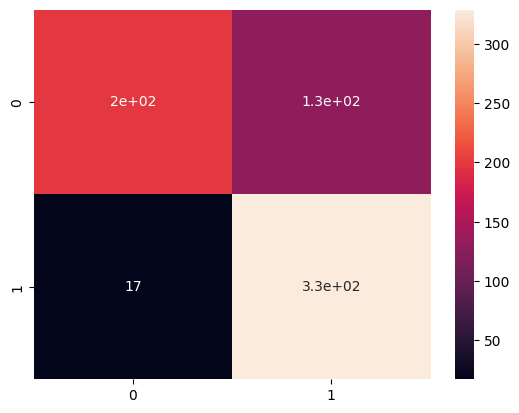

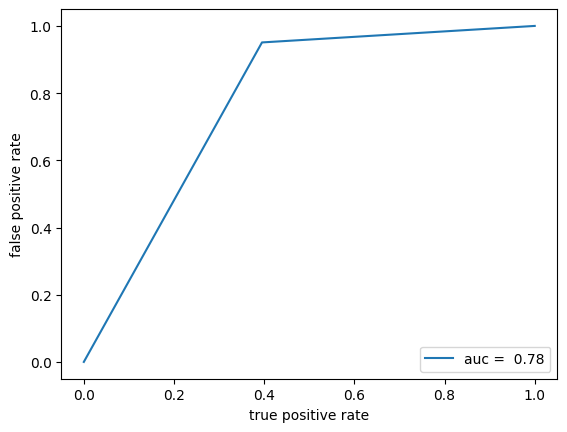

----------------------------------------------------------------------------------------------------



******************** bayes TestingData metrics ********************

accuracy:  0.77
precision:  0.69
recall:  0.89
f1:  0.78
roc_auc:  0.78
confusion matrix:
[[62 31]
 [ 8 68]]



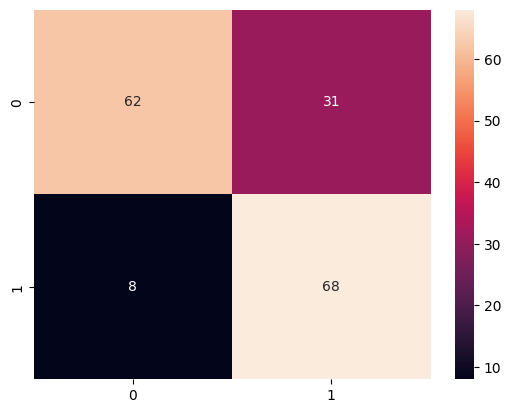

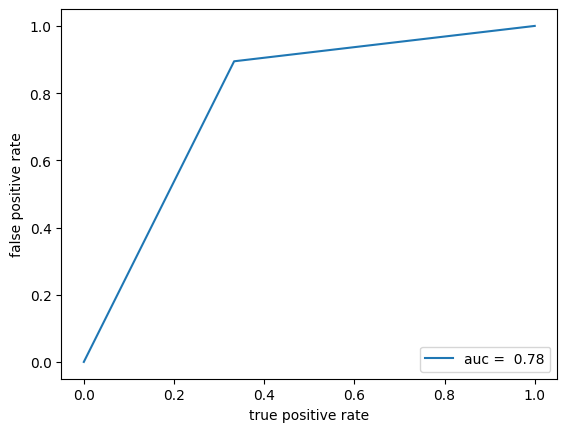

----------------------------------------------------------------------------------------------------





In [20]:
log_metrics(y_train, y_train_bayes, legend='bayes TrainingData metrics')
log_metrics(y_test, y_test_bayes, legend='bayes TestingData metrics')

### Decision Tree Model

In [21]:
tree_model = DecisionTreeClassifier(criterion="entropy")
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

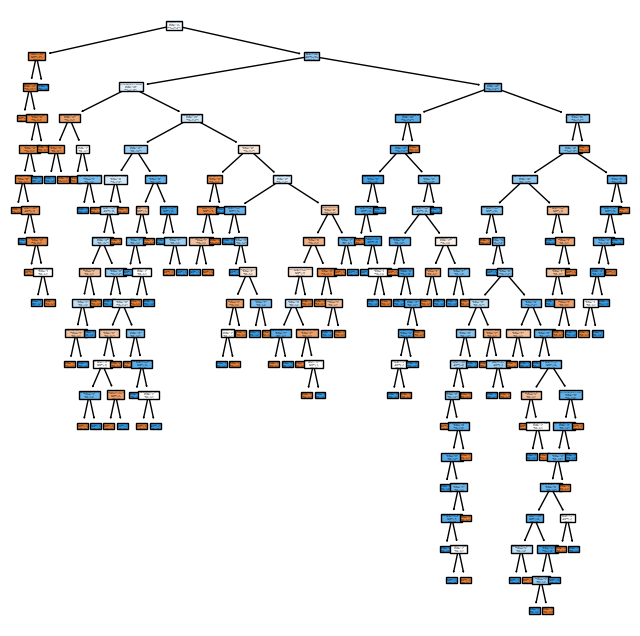

In [22]:
# visualize the tree

fig = plt.figure(figsize=(8,8))

_ = tree.plot_tree(
    tree_model, 
    feature_names=df.columns[:-1],  
    class_names=['No', 'Yes'],
    filled=True
)

In [23]:
text_representation = tree.export_text(tree_model)
print(text_representation)

|--- feature_9 <= 0.50
|   |--- feature_7 <= 547.50
|   |   |--- feature_3 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_3 >  0.50
|   |   |   |--- feature_5 <= 4931.00
|   |   |   |   |--- feature_5 <= 4802.50
|   |   |   |   |   |--- feature_7 <= 136.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_7 >  136.50
|   |   |   |   |   |   |--- feature_7 <= 137.59
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_7 >  137.59
|   |   |   |   |   |   |   |--- feature_5 <= 4073.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_5 >  4073.50
|   |   |   |   |   |   |   |   |--- feature_7 <= 300.44
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_7 >  300.44
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_5 >  4802.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_5 >  4931.00
|   |   |   |   |--- class: 0


- print decision tree metrics on **train** and **test** data

******************** decision tree TrainingData metrics ********************

accuracy:  1.00
precision:  1.00
recall:  1.00
f1:  1.00
roc_auc:  1.00
confusion matrix:
[[329   0]
 [  0 346]]



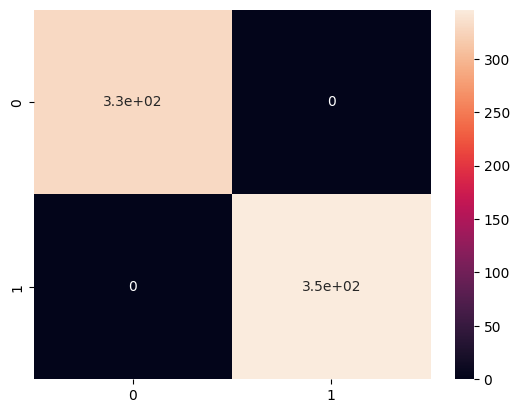

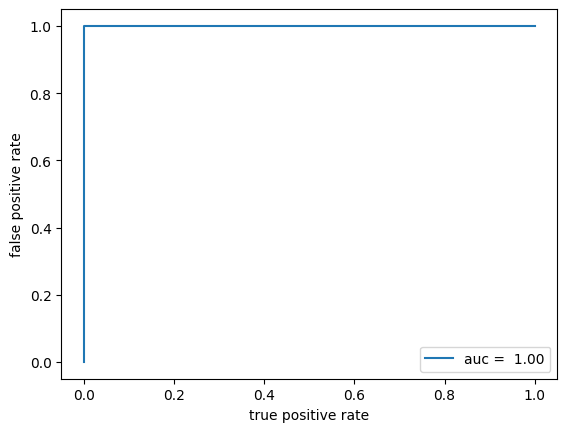

----------------------------------------------------------------------------------------------------



******************** decision tree TestingData metrics ********************

accuracy:  0.79
precision:  0.82
recall:  0.67
f1:  0.74
roc_auc:  0.78
confusion matrix:
[[82 11]
 [25 51]]



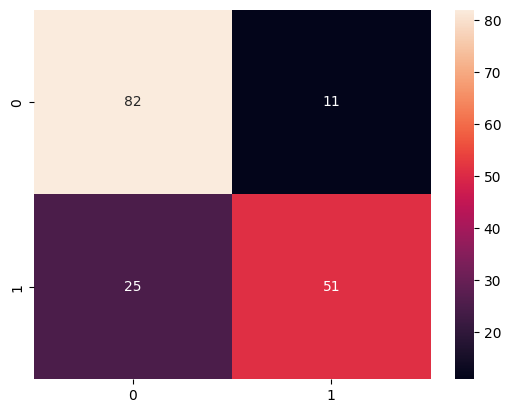

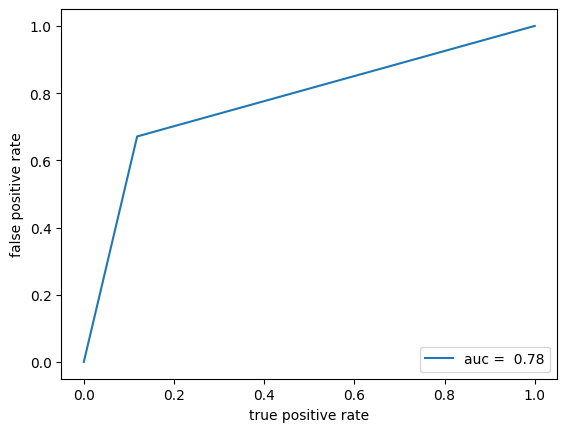

----------------------------------------------------------------------------------------------------





In [24]:
log_metrics(y_train, tree_model.predict(X_train), legend='decision tree TrainingData metrics')
log_metrics(y_test, tree_model.predict(X_test), legend='decision tree TestingData metrics')

### Logistic Regression Model 

[normalize the data when using logistic regression](https://scikit-learn.org/stable/modules/preprocessing.html)

In [25]:
logistic_model = make_pipeline(StandardScaler(), LogisticRegression())
logistic_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

again, print metrics on **training**, and **testing** data

******************** logistic TrainingData metrics ********************

accuracy:  0.79
precision:  0.73
recall:  0.92
f1:  0.81
roc_auc:  0.78
confusion matrix:
[[212 117]
 [ 28 318]]



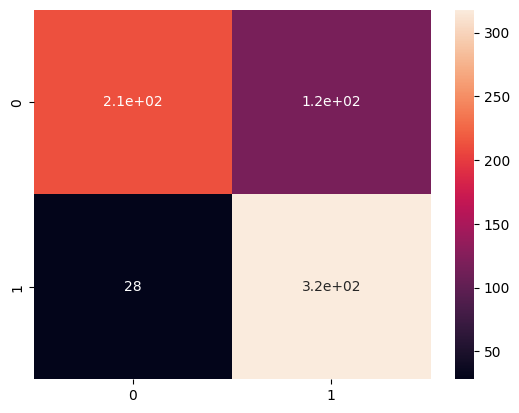

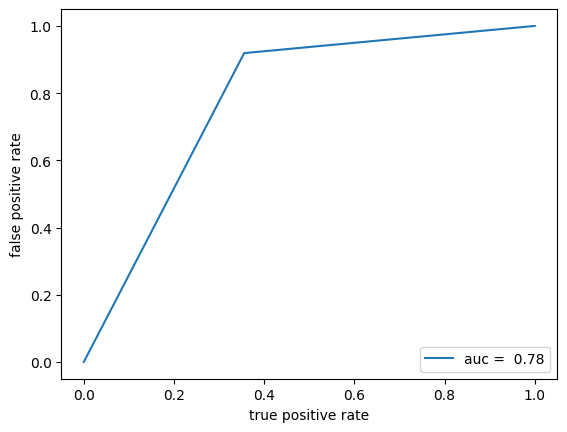

----------------------------------------------------------------------------------------------------



******************** logistic TestingData metrics ********************

accuracy:  0.78
precision:  0.70
recall:  0.87
f1:  0.78
roc_auc:  0.78
confusion matrix:
[[65 28]
 [10 66]]



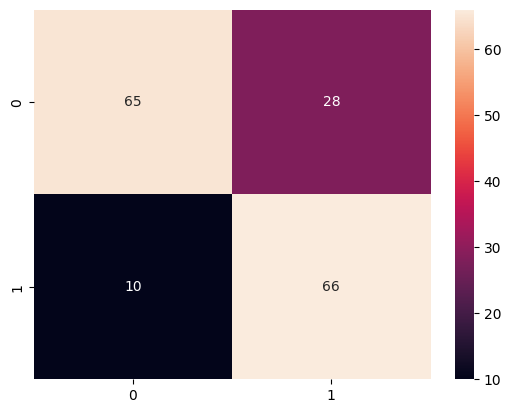

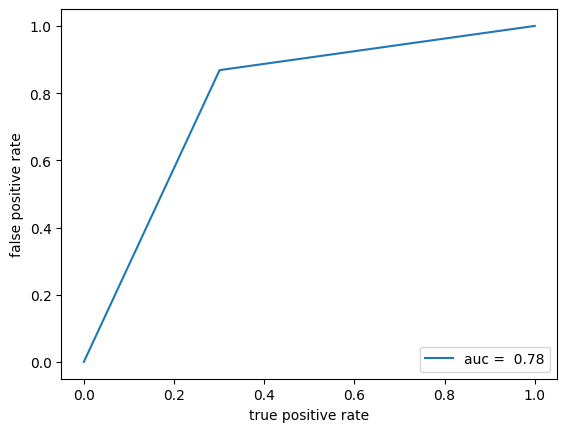

----------------------------------------------------------------------------------------------------





In [26]:
log_metrics(y_train, logistic_model.predict(X_train), legend='logistic TrainingData metrics')
log_metrics(y_test, logistic_model.predict(X_test), legend='logistic TestingData metrics')

### SVM Model

it's recommended to scale the data, as noted [here](https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use)

In [27]:
svm_model = make_pipeline(StandardScaler(), svm.SVC())
svm_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

print metrics on **training** and **testing** data

******************** SVM TrainingData metrics ********************

accuracy:  0.83
precision:  0.76
recall:  0.96
f1:  0.85
roc_auc:  0.82
confusion matrix:
[[226 103]
 [ 15 331]]



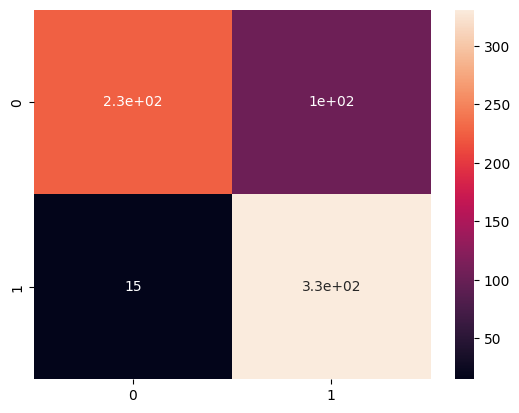

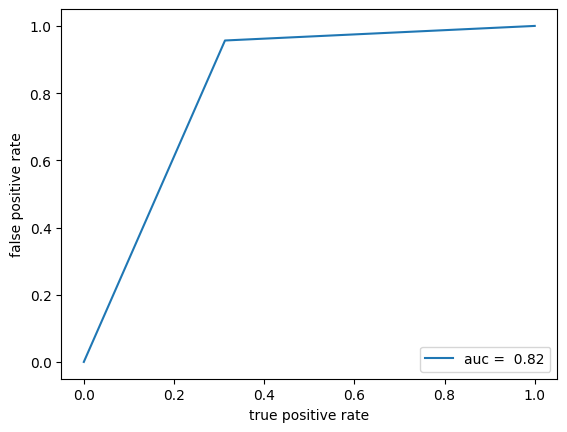

----------------------------------------------------------------------------------------------------



******************** SVM TestingData metrics ********************

accuracy:  0.75
precision:  0.68
recall:  0.82
f1:  0.74
roc_auc:  0.75
confusion matrix:
[[64 29]
 [14 62]]



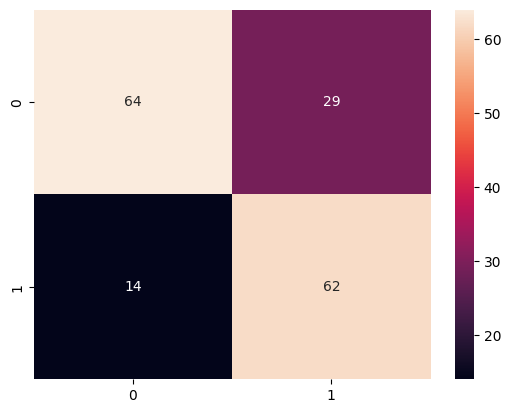

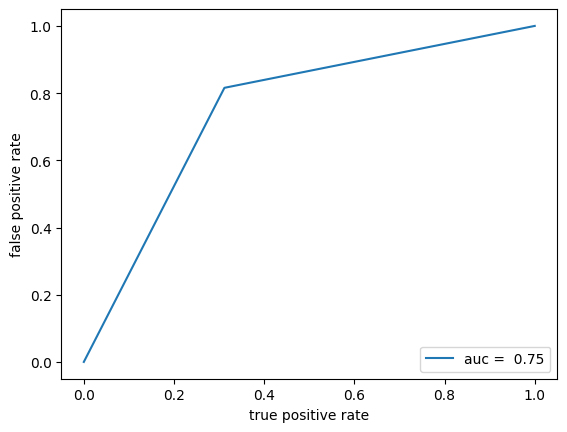

----------------------------------------------------------------------------------------------------





In [28]:
log_metrics(y_train, svm_model.predict(X_train), legend='SVM TrainingData metrics')
log_metrics(y_test, svm_model.predict(X_test), legend='SVM TestingData metrics')

### KNN Model

use 5 neighbors

In [29]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

print metrics on both **training** and **testing** data

******************** KNN TrainingData metrics ********************

accuracy:  0.78
precision:  0.80
recall:  0.76
f1:  0.78
roc_auc:  0.78
confusion matrix:
[[265  64]
 [ 82 264]]



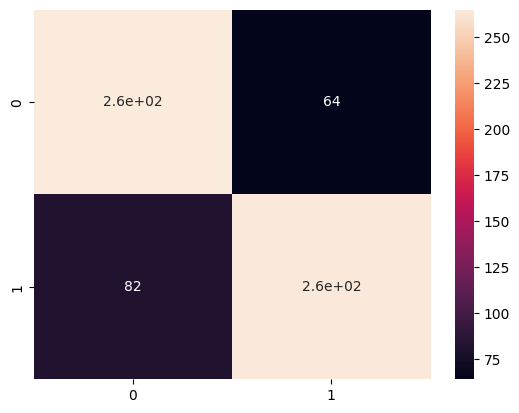

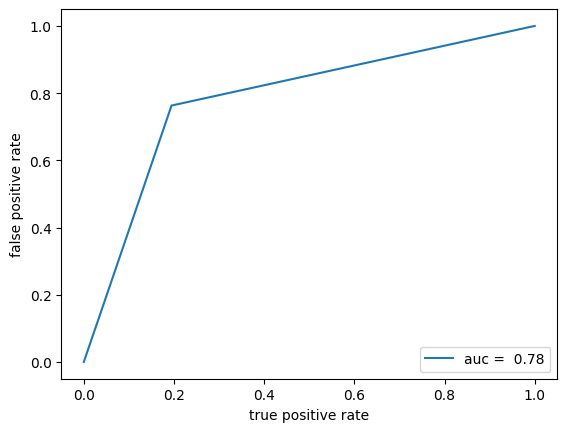

----------------------------------------------------------------------------------------------------



******************** KNN TestingData metrics ********************

accuracy:  0.64
precision:  0.59
recall:  0.62
f1:  0.61
roc_auc:  0.64
confusion matrix:
[[61 32]
 [29 47]]



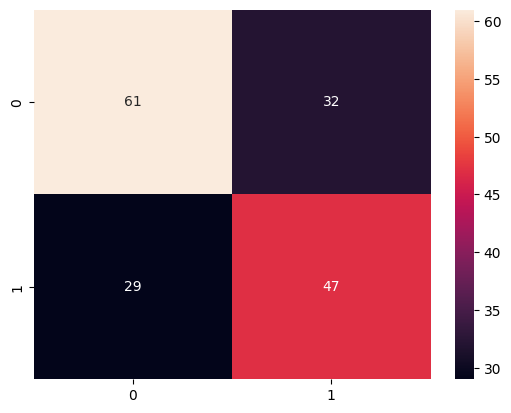

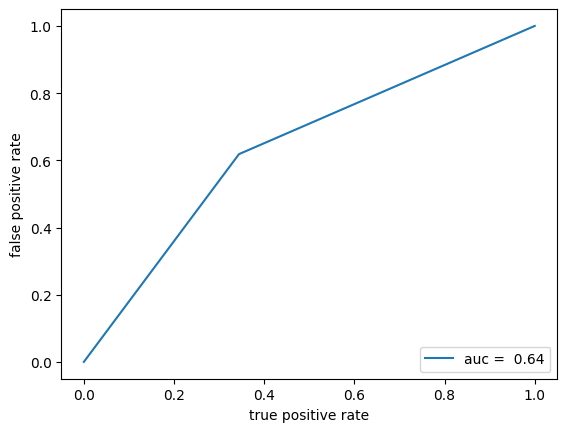

----------------------------------------------------------------------------------------------------





In [30]:
log_metrics(y_train, knn_model.predict(X_train), legend='KNN TrainingData metrics')
log_metrics(y_test, knn_model.predict(X_test), legend='KNN TestingData metrics')

## Saving Models using `pickle`

saving models so that we can use them later without the need to re-train them from scratch

In [31]:
models_to_save = {
    'bayes': {'discrete': bayes_model_discrete, 'continuous': bayes_model_continuous},
    'tree': tree_model,
    'logistic': logistic_model,
    'svm': svm_model,
    'knn': knn_model,
}

for model_name, model_data in models_to_save.items():
    path = Path('./pickled_models') / model_name
    with open(path, 'wb') as file:
        pickle.dump(model_data, file)

## Exporting Models

`m2cgen` library allows us to export model prediction function to different languages.

although not all models are supported

In [32]:
print(m2cgen.export_to_php(tree_model))

<?php
function score(array $input) {
    $var0 = array();
    if ($input[9] <= 0.5) {
        if ($input[7] <= 547.5) {
            if ($input[3] <= 0.5) {
                $var0 = array(1.0, 0.0);
            } else {
                if ($input[5] <= 4931.0) {
                    if ($input[5] <= 4802.5) {
                        if ($input[7] <= 136.5) {
                            $var0 = array(1.0, 0.0);
                        } else {
                            if ($input[7] <= 137.58985900878906) {
                                $var0 = array(0.0, 1.0);
                            } else {
                                if ($input[5] <= 4073.5) {
                                    $var0 = array(1.0, 0.0);
                                } else {
                                    if ($input[7] <= 300.4374542236328) {
                                        $var0 = array(0.0, 1.0);
                                    } else {
                                        $var0 = ar

## Using saved models in prediction

in the folder [predictor/predictor.py](./predictor/predictor.py) we define the function `predict` which takes
python dict sample like:

```{"Gender": "Male", "Married": "Yes", ..}```

and returns dict of models predictions, and the majority vote:

```{"bayes": 0, "tree": 1, "logistic": 1, "svm": 0, "knn": 1, "majority_vote": 1}```

and that file ([predictor/predictor.py](./predictor/predictor.py)) we will use
when building the python api.

the `predictor` will make sure to encoder the attributes, e.g. convert gender to 0/1

In [33]:
import warnings
warnings.filterwarnings('ignore')

our predictor, exists in predictor/predictor.py file next to this notebook

make sure to copy `pickled_models` folder to `predictor` folder

In [34]:
import predictor

z = {
    "Gender": "Male",
    "Married": "No",
    "Dependents": "3+",
    "Education": "Graduate",
    "Self_Employed": "Yes",
    "ApplicantIncome": 19795,
    "CoapplicantIncome": 4581.16,
    "LoanAmount": 558.3,
    "Loan_Amount_Term": 360.0,
    "Credit_History": "1",
}

predictor.predict(z)

{'bayes': 1,
 'tree': 1,
 'logistic': 0,
 'svm': 1,
 'knn': 1,
 'voting_majority': 1}